# Subject-Grouped K-Fold Evaluation
This notebook mirrors the baseline mHealth pipeline while evaluating grouped subject-wise folds.

In [1]:

import copy
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

try:
    from sklearn.metrics import (
        ConfusionMatrixDisplay,
        classification_report,
        confusion_matrix,
        f1_score,
    )
except ImportError:
    ConfusionMatrixDisplay = classification_report = confusion_matrix = f1_score = None
    print("Warning: scikit-learn is not available. Metric reports will be limited.")


In [2]:

plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)


In [3]:

DATA_DIR = Path.cwd() / "MHEALTHDATASET"

COLUMN_NAMES = [
    "acc_chest_x", "acc_chest_y", "acc_chest_z",
    "ecg_1", "ecg_2",
    "acc_ankle_x", "acc_ankle_y", "acc_ankle_z",
    "gyro_ankle_x", "gyro_ankle_y", "gyro_ankle_z",
    "mag_ankle_x", "mag_ankle_y", "mag_ankle_z",
    "acc_wrist_x", "acc_wrist_y", "acc_wrist_z",
    "gyro_wrist_x", "gyro_wrist_y", "gyro_wrist_z",
    "mag_wrist_x", "mag_wrist_y", "mag_wrist_z",
    "label",
]

FEATURE_COLUMNS = COLUMN_NAMES[:-1]

ACTIVITY_MAP = {
    1: "Standing still",
    2: "Sitting and relaxing",
    3: "Lying down",
    4: "Walking",
    5: "Climbing stairs",
    6: "Waist bends forward",
    7: "Frontal arms elevation",
    8: "Knees bending (crouch)",
    9: "Cycling",
    10: "Jogging",
    11: "Running",
    12: "Jump front & back",
}

SAMPLING_RATE_HZ = 50

subject_files = sorted(DATA_DIR.glob("mHealth_subject*.log"))

if not subject_files:
    raise FileNotFoundError(f"Could not find any subject files under {DATA_DIR}")

print(f"Subject files: {len(subject_files)}")
print(subject_files[:3])


Subject files: 10
[WindowsPath('c:/Users/이예일/OneDrive/바탕 화면/대학/3학년2학기/기학프/MHEALTHDATASET/mHealth_subject1.log'), WindowsPath('c:/Users/이예일/OneDrive/바탕 화면/대학/3학년2학기/기학프/MHEALTHDATASET/mHealth_subject10.log'), WindowsPath('c:/Users/이예일/OneDrive/바탕 화면/대학/3학년2학기/기학프/MHEALTHDATASET/mHealth_subject2.log')]


In [4]:

def summarize_labels(files: Iterable[Path], chunksize: int = 200_000) -> Tuple[Dict[str, Dict[int, int]], Dict[int, int]]:
    per_subject: Dict[str, Dict[int, int]] = {}
    total_counter: Counter = Counter()
    for path in files:
        counter = Counter()
        for chunk in pd.read_csv(
            path,
            sep="	",
            header=None,
            usecols=[23],
            names=["label"],
            chunksize=chunksize,
        ):
            labels = chunk["label"].astype(int)
            chunk_counts = Counter(labels)
            counter.update(chunk_counts)
            total_counter.update(chunk_counts)
        per_subject[path.name] = dict(sorted(counter.items()))
    return per_subject, dict(sorted(total_counter.items()))


per_subject_counts, total_counts = summarize_labels(subject_files)

summary_rows = []
label_ids = sorted({label for counts in per_subject_counts.values() for label in counts})
for name, counts in per_subject_counts.items():
    row = {"subject": name, "samples": sum(counts.values())}
    for label in label_ids:
        row[f"L{label:02d}"] = counts.get(label, 0)
    summary_rows.append(row)

label_summary_df = pd.DataFrame(summary_rows).set_index("subject")
display(label_summary_df)

print("Total samples:", sum(total_counts.values()))
print("Label distribution:", total_counts)


,samples,L00,L01,L02,L03,L04,L05,L06,L07,L08,L09,L10,L11,L12
subject,,,,,,,,,,,,,,
mHealth_subject1.log,161280,126106,3072,3072,3072,3072,3072,3072,3072,3379,3072,3072,3072,1075
mHealth_subject10.log,98304,64614,3072,3072,3072,3072,3072,2458,2765,2867,3072,3072,3072,1024
mHealth_subject2.log,130561,95029,3072,3072,3072,3072,3072,3174,3328,3430,3072,3072,3072,1024
mHealth_subject3.log,122112,86732,3072,3072,3072,3072,3072,3226,3379,3175,3072,3072,3072,1024
mHealth_subject4.log,116736,81408,3072,3072,3072,3072,3072,3328,3277,3123,3072,3072,3072,1024
mHealth_subject5.log,119808,85861,3072,3072,3072,3072,3072,2765,2868,2714,3072,3072,3072,1024
mHealth_subject6.log,98304,66099,3072,3072,3072,3072,3072,2202,2099,2304,3072,3072,3072,1024
mHealth_subject7.log,104448,70195,3072,3072,3072,3072,3072,3072,2765,2816,3072,3072,3072,1024
mHealth_subject8.log,129024,95692,3072,3072,3072,3072,3072,2151,3021,2560,3072,3072,3072,1024


Total samples: 1215745
Label distribution: {0: 872550, 1: 30720, 2: 30720, 3: 30720, 4: 30720, 5: 30720, 6: 28315, 7: 29441, 8: 29337, 9: 30720, 10: 30720, 11: 30720, 12: 10342}


In [5]:

def compute_feature_stats(files: Iterable[Path], chunksize: int = 100_000) -> pd.DataFrame:
    min_vals = max_vals = sum_vals = sumsq_vals = None
    count = 0

    for path in files:
        for chunk in pd.read_csv(
            path,
            sep="	",
            header=None,
            names=COLUMN_NAMES,
            usecols=range(len(COLUMN_NAMES)),
            chunksize=chunksize,
        ):
            data = chunk[FEATURE_COLUMNS].to_numpy(dtype=np.float64)
            if min_vals is None:
                min_vals = data.min(axis=0)
                max_vals = data.max(axis=0)
                sum_vals = data.sum(axis=0)
                sumsq_vals = np.square(data).sum(axis=0)
                count = data.shape[0]
            else:
                min_vals = np.minimum(min_vals, data.min(axis=0))
                max_vals = np.maximum(max_vals, data.max(axis=0))
                sum_vals += data.sum(axis=0)
                sumsq_vals += np.square(data).sum(axis=0)
                count += data.shape[0]

    mean = sum_vals / count
    variance = sumsq_vals / count - np.square(mean)
    std = np.sqrt(np.maximum(variance, 1e-12))

    return pd.DataFrame(
        {
            "min": min_vals,
            "max": max_vals,
            "mean": mean,
            "std": std,
        },
        index=FEATURE_COLUMNS,
    )


feature_stats_df = compute_feature_stats(subject_files)
display(feature_stats_df.round(4))

normalization_stats = {
    "mean": feature_stats_df["mean"].to_numpy(),
    "std": feature_stats_df["std"].replace(0, 1e-6).to_numpy(),
}


,min,max,mean,std
acc_chest_x,-22.4380,19.0940,-8.5224,4.0753
acc_chest_y,-20.1880,20.9270,-0.2140,2.1390
acc_chest_z,-18.4010,26.1960,-1.0559,3.5742
ecg_1,-8.6196,8.5149,-0.0051,0.7466
ecg_2,-8.6196,8.5191,-0.0045,0.7270
acc_ankle_x,-22.1460,20.0540,1.4942,3.8265
acc_ankle_y,-19.6190,21.1610,-9.6929,4.1713
acc_ankle_z,-19.3730,25.0150,-0.9548,5.4618
gyro_ankle_x,-2.1466,60.4840,-0.0016,0.4912
gyro_ankle_y,-7.7899,2.0113,-0.6166,0.3546


In [6]:

def majority_vote(labels: np.ndarray, ignore_zero: bool = False) -> int:
    if ignore_zero:
        labels = labels[labels != 0]
        if labels.size == 0:
            return 0
    values, counts = np.unique(labels, return_counts=True)
    return int(values[np.argmax(counts)])


def generate_windows(
    df: pd.DataFrame,
    window_size: int = 250,
    step_size: int = 125,
    include_null: bool = False,
    majority_ignore_zero: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    features = df[FEATURE_COLUMNS].to_numpy(dtype=np.float32)
    labels = df["label"].to_numpy(dtype=np.int64)

    windows: List[np.ndarray] = []
    window_labels: List[int] = []

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = features[start:end]
        label = majority_vote(labels[start:end], ignore_zero=majority_ignore_zero)
        if not include_null and label == 0:
            continue
        windows.append(window)
        window_labels.append(label)

    if not windows:
        return (
            np.empty((0, window_size, len(FEATURE_COLUMNS)), dtype=np.float32),
            np.empty(0, dtype=np.int64),
        )

    return np.stack(windows), np.array(window_labels, dtype=np.int64)


example_df = pd.read_csv(
    subject_files[0],
    sep="	",
    header=None,
    names=COLUMN_NAMES,
    nrows=10_000,
)
example_df["label"] = example_df["label"].astype(int)
example_windows, example_labels = generate_windows(example_df, window_size=250, step_size=125)
print(f"Example windows: {len(example_windows)}, shape={example_windows.shape}")
print("Label counts:", Counter(example_labels))


Example windows: 26, shape=(26, 250, 23)
Label counts: Counter({np.int64(1): 26})


In [7]:

class MHealthWindowDataset(Dataset):
    """Windowed mHealth dataset with optional normalization."""

    def __init__(
        self,
        subjects: Iterable[int],
        data_dir: Path = DATA_DIR,
        window_size: int = 250,
        step_size: int = 125,
        include_null: bool = False,
        normalization: Optional[Dict[str, np.ndarray]] = None,
    ) -> None:
        self.subjects = list(subjects)
        self.data_dir = data_dir
        self.window_size = window_size
        self.step_size = step_size
        self.include_null = include_null
        self.normalization = normalization

        self.inputs: torch.Tensor
        self.targets: torch.Tensor
        self._prepare()

    def _load_subject(self, subject_id: int) -> pd.DataFrame:
        path = self.data_dir / f"mHealth_subject{subject_id}.log"
        if not path.exists():
            raise FileNotFoundError(path)
        df = pd.read_csv(path, sep="	", header=None, names=COLUMN_NAMES)
        df["label"] = df["label"].astype(int)

        features = df[FEATURE_COLUMNS].to_numpy(dtype=np.float32)
        if self.normalization is not None:
            mean = np.asarray(self.normalization["mean"], dtype=np.float32)
            std = np.asarray(self.normalization["std"], dtype=np.float32)
            features = (features - mean) / std
        df.loc[:, FEATURE_COLUMNS] = features
        return df

    def _prepare(self) -> None:
        window_tensors: List[torch.Tensor] = []
        label_tensors: List[torch.Tensor] = []

        for subject_id in self.subjects:
            df = self._load_subject(subject_id)
            windows, labels = generate_windows(
                df,
                window_size=self.window_size,
                step_size=self.step_size,
                include_null=self.include_null,
                majority_ignore_zero=not self.include_null,
            )
            if windows.size == 0:
                continue
            window_tensor = torch.from_numpy(windows).permute(0, 2, 1).contiguous()
            label_tensor = torch.from_numpy(labels)
            window_tensors.append(window_tensor)
            label_tensors.append(label_tensor)

        if window_tensors:
            self.inputs = torch.cat(window_tensors, dim=0)
            self.targets = torch.cat(label_tensors, dim=0)
        else:
            num_features = len(FEATURE_COLUMNS)
            self.inputs = torch.empty((0, num_features, self.window_size), dtype=torch.float32)
            self.targets = torch.empty((0,), dtype=torch.long)

    def __len__(self) -> int:
        return self.targets.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.inputs[idx], self.targets[idx]


In [8]:

torch.manual_seed(42)
np.random.seed(42)

example_dataset = MHealthWindowDataset([1], window_size=250, step_size=125, normalization=normalization_stats)
print(f"Subject 1 windows: {len(example_dataset)}")


Subject 1 windows: 305


In [9]:
class CNNLSTMBaseline(nn.Module):
    """CNN front-end followed by LSTM for mHealth classification."""

    def __init__(
        self,
        in_channels: int = len(FEATURE_COLUMNS),
        cnn_channels: int = 128,
        lstm_hidden: int = 128,
        num_layers: int = 1,
        dropout: float = 0.3,
        num_classes: int = len(ACTIVITY_MAP) + 1,
    ) -> None:
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2, stride=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, cnn_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
        )
        self.lstm = nn.LSTM(
            input_size=cnn_channels,
            hidden_size=lstm_hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(p=dropout)
        self.classifier = nn.Linear(lstm_hidden * 2, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        sequence = features.permute(0, 2, 1)
        outputs, _ = self.lstm(sequence)
        pooled = self.dropout(outputs[:, -1])
        return self.classifier(pooled)

default_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {default_device}")

@dataclass
class TrainConfig:
    epochs: int = 30
    lr: float = 1e-3
    weight_decay: float = 1e-4
    grad_clip: Optional[float] = None
    device: str = default_device

model = CNNLSTMBaseline()
print(model)


Using device: cpu
CNNLSTMBaseline(
  (feature_extractor): Sequential(
    (0): Conv1d(23, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier): Linear(in_features=256, out_features=13, bias=True)
)


In [10]:

def create_class_weights(labels: Iterable[int], ignore_zero: bool = False) -> torch.Tensor:
    counts = Counter(labels)
    if ignore_zero and 0 in counts:
        counts.pop(0)
    if not counts:
        return torch.ones(len(ACTIVITY_MAP) + 1, dtype=torch.float32)
    max_count = max(counts.values())
    weights = torch.ones(len(ACTIVITY_MAP) + 1, dtype=torch.float32)
    for label, count in counts.items():
        weights[label] = max_count / count
    return weights


def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion,
    optimizer,
    device: str,
    grad_clip: Optional[float] = None,
) -> Tuple[float, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running_loss += loss.item() * targets.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    return running_loss / total, correct / total


def evaluate(model: nn.Module, dataloader: DataLoader, criterion, device: str) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * targets.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return running_loss / total, correct / total


def predict(model: nn.Module, dataloader: DataLoader, device: str) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    all_preds: List[np.ndarray] = []
    all_targets: List[np.ndarray] = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets.numpy())
    return np.concatenate(all_preds), np.concatenate(all_targets)


Fold 1: test=(1, 2), val=(3, 4), train=[5, 6, 7, 8, 9, 10]
Windows - train: 1770, val: 615, test: 613
  epoch 01 | train_loss=2.0670 acc=0.491 | val_loss=1.9032 acc=0.577
  epoch 05 | train_loss=0.0749 acc=0.988 | val_loss=0.4866 acc=0.886
  epoch 10 | train_loss=0.0069 acc=1.000 | val_loss=0.8667 acc=0.865
  epoch 15 | train_loss=0.0101 acc=0.998 | val_loss=0.6935 acc=0.868
  epoch 20 | train_loss=0.0359 acc=0.990 | val_loss=0.8589 acc=0.798
  epoch 25 | train_loss=0.0031 acc=1.000 | val_loss=0.7695 acc=0.823
  epoch 30 | train_loss=0.0138 acc=0.997 | val_loss=0.5164 acc=0.911
                        precision    recall  f1-score   support

        Standing still      0.612     1.000     0.759        52
  Sitting and relaxing      0.926     0.481     0.633        52
            Lying down      1.000     0.500     0.667        54
               Walking      1.000     1.000     1.000        53
       Climbing stairs      0.736     0.981     0.841        54
   Waist bends forward      1.

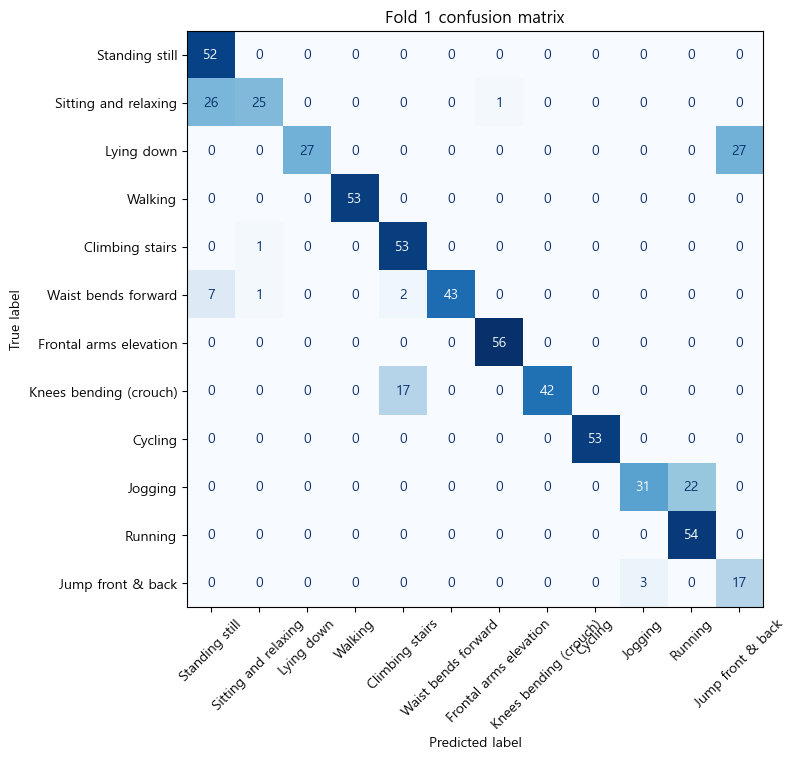

Fold 2: test=(3, 4), val=(5, 6), train=[1, 2, 7, 8, 9, 10]
Windows - train: 1805, val: 578, test: 615
  epoch 01 | train_loss=2.0493 acc=0.480 | val_loss=1.7905 acc=0.497
  epoch 05 | train_loss=0.1351 acc=0.963 | val_loss=0.5963 acc=0.853
  epoch 10 | train_loss=0.0591 acc=0.986 | val_loss=0.2398 acc=0.926
  epoch 15 | train_loss=0.0256 acc=0.997 | val_loss=0.2021 acc=0.934
  epoch 20 | train_loss=0.0207 acc=0.996 | val_loss=0.5696 acc=0.894
  epoch 25 | train_loss=0.0453 acc=0.987 | val_loss=0.1264 acc=0.958
  epoch 30 | train_loss=0.0147 acc=0.998 | val_loss=0.3082 acc=0.924
                        precision    recall  f1-score   support

        Standing still      1.000     1.000     1.000        54
  Sitting and relaxing      1.000     0.500     0.667        54
            Lying down      1.000     1.000     1.000        53
               Walking      1.000     0.944     0.971        54
       Climbing stairs      0.662     1.000     0.797        53
   Waist bends forward      1.

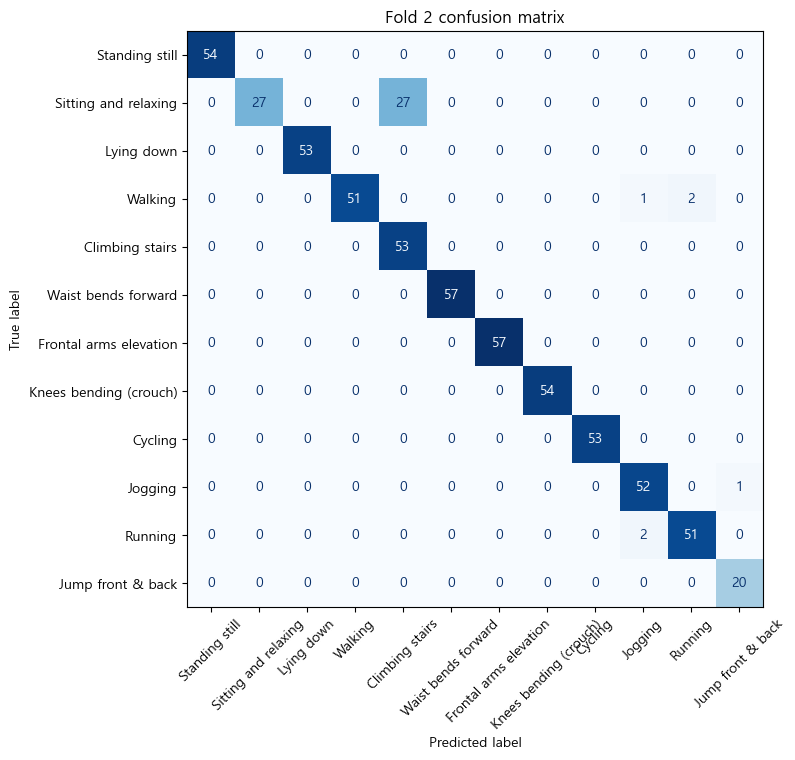

Fold 3: test=(5, 6), val=(7, 8), train=[1, 2, 3, 4, 9, 10]
Windows - train: 1816, val: 604, test: 578
  epoch 01 | train_loss=2.0337 acc=0.529 | val_loss=1.8850 acc=0.570
  epoch 05 | train_loss=0.0880 acc=0.985 | val_loss=1.6903 acc=0.558
  epoch 10 | train_loss=0.0221 acc=0.994 | val_loss=1.4195 acc=0.608
  epoch 15 | train_loss=0.0150 acc=0.996 | val_loss=1.4495 acc=0.621
  epoch 20 | train_loss=0.0219 acc=0.994 | val_loss=1.9310 acc=0.619
  epoch 25 | train_loss=0.0143 acc=0.998 | val_loss=1.6197 acc=0.613
  epoch 30 | train_loss=0.0211 acc=0.996 | val_loss=1.7750 acc=0.657
                        precision    recall  f1-score   support

        Standing still      0.607     1.000     0.755        54
  Sitting and relaxing      1.000     0.500     0.667        54
            Lying down      1.000     1.000     1.000        52
               Walking      0.667     0.077     0.138        52
       Climbing stairs      0.607     0.962     0.745        53
   Waist bends forward      1.

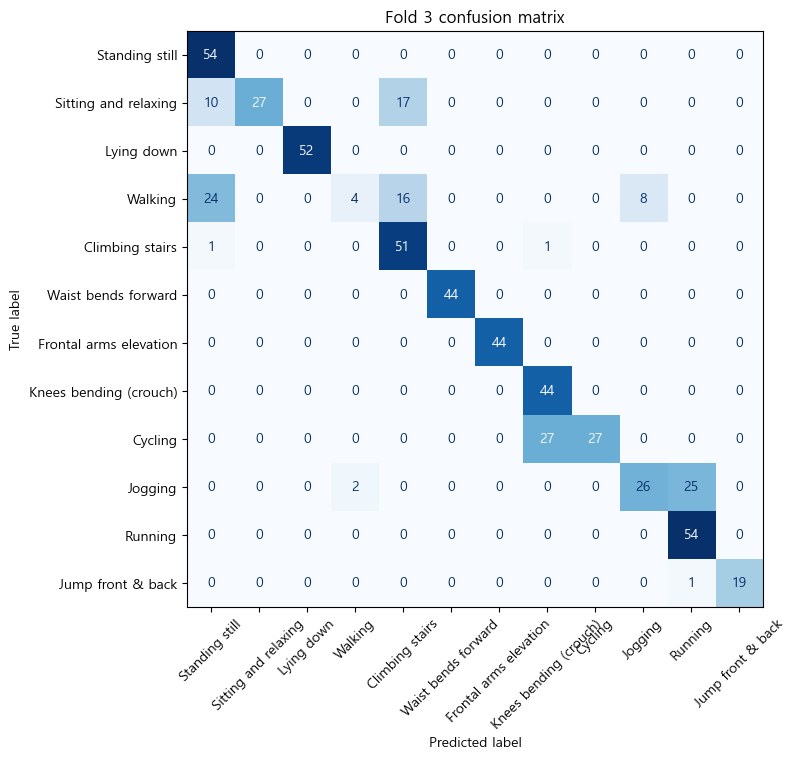

Fold 4: test=(7, 8), val=(9, 10), train=[1, 2, 3, 4, 5, 6]
Windows - train: 1806, val: 588, test: 604
  epoch 01 | train_loss=2.0436 acc=0.454 | val_loss=1.7256 acc=0.595
  epoch 05 | train_loss=0.1002 acc=0.980 | val_loss=0.0685 acc=0.991
  epoch 10 | train_loss=0.1099 acc=0.962 | val_loss=0.1547 acc=0.956
  epoch 15 | train_loss=0.0636 acc=0.983 | val_loss=0.2696 acc=0.918
  epoch 20 | train_loss=0.0174 acc=0.998 | val_loss=0.0375 acc=0.985
  epoch 25 | train_loss=0.0116 acc=0.999 | val_loss=0.2675 acc=0.900
  epoch 30 | train_loss=0.0127 acc=0.997 | val_loss=0.1195 acc=0.964
                        precision    recall  f1-score   support

        Standing still      0.794     1.000     0.885        54
  Sitting and relaxing      0.697     1.000     0.822        53
            Lying down      1.000     1.000     1.000        53
               Walking      0.863     0.830     0.846        53
       Climbing stairs      0.589     0.500     0.541        66
   Waist bends forward      0.

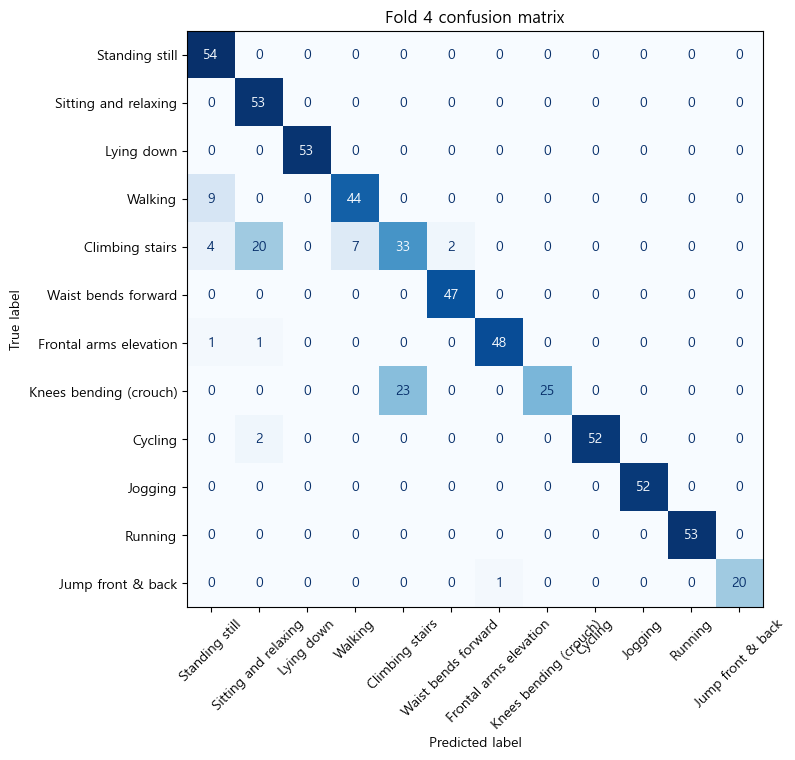

Fold 5: test=(9, 10), val=(1, 2), train=[3, 4, 5, 6, 7, 8]
Windows - train: 1797, val: 613, test: 588
  epoch 01 | train_loss=2.0977 acc=0.442 | val_loss=1.7800 acc=0.540
  epoch 05 | train_loss=0.2941 acc=0.919 | val_loss=0.9477 acc=0.710
  epoch 10 | train_loss=0.0742 acc=0.992 | val_loss=0.6869 acc=0.781
  epoch 15 | train_loss=0.0995 acc=0.980 | val_loss=0.7088 acc=0.773
  epoch 20 | train_loss=0.0374 acc=0.995 | val_loss=0.5233 acc=0.793
  epoch 25 | train_loss=0.0400 acc=0.995 | val_loss=0.5304 acc=0.783
  epoch 30 | train_loss=0.0267 acc=0.996 | val_loss=0.7507 acc=0.809
                        precision    recall  f1-score   support

        Standing still      1.000     1.000     1.000        53
  Sitting and relaxing      1.000     0.566     0.723        53
            Lying down      1.000     1.000     1.000        53
               Walking      1.000     0.808     0.894        52
       Climbing stairs      0.831     0.925     0.875        53
   Waist bends forward      0.

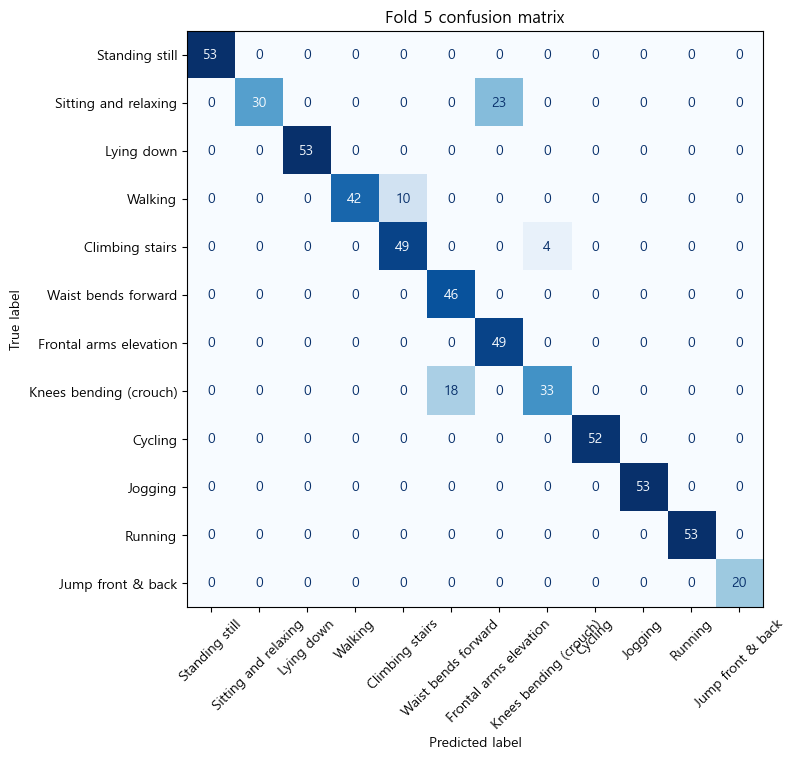

,fold,epoch,train_loss,train_acc,val_loss,val_acc
0,1,1,2.066960,0.490960,1.903221,0.577236
1,1,2,0.801198,0.831073,0.938265,0.778862
2,1,3,0.187223,0.976836,0.744858,0.839024
3,1,4,0.099181,0.983616,0.810057,0.821138
4,1,5,0.074929,0.988136,0.486595,0.886179
...,...,...,...,...,...,...
145,5,26,0.040066,0.991096,0.906217,0.761827
146,5,27,0.026278,0.997774,0.957559,0.724307
147,5,28,0.050003,0.988870,1.044906,0.781403
148,5,29,0.040931,0.993322,0.838582,0.807504


,fold,test_subjects,val_subjects,train_subjects,test_loss,test_acc,f1_macro
0,1,"(1, 2)","(3, 4)","(5, 6, 7, 8, 9, 10)",0.694603,0.825449,0.807775
1,2,"(3, 4)","(5, 6)","(1, 2, 7, 8, 9, 10)",0.473989,0.946341,0.944660
2,3,"(5, 6)","(7, 8)","(1, 2, 3, 4, 9, 10)",1.111714,0.771626,0.758974
3,4,"(7, 8)","(9, 10)","(1, 2, 3, 4, 5, 6)",0.385318,0.884106,0.890385
4,5,"(9, 10)","(1, 2)","(3, 4, 5, 6, 7, 8)",0.250754,0.906463,0.907316


Mean macro F1 across folds: 0.8618


In [11]:

GROUPED_SUBJECTS = [
    (1, 2),
    (3, 4),
    (5, 6),
    (7, 8),
    (9, 10),
]
all_subject_ids = [subject for group in GROUPED_SUBJECTS for subject in group]

config = TrainConfig()
device = config.device

fold_summaries: List[Dict[str, object]] = []
history_frames: List[pd.DataFrame] = []

for fold_idx, test_pair in enumerate(GROUPED_SUBJECTS):
    val_pair = GROUPED_SUBJECTS[(fold_idx + 1) % len(GROUPED_SUBJECTS)]
    train_subjects = sorted(set(all_subject_ids) - set(test_pair) - set(val_pair))

    print(f"Fold {fold_idx + 1}: test={test_pair}, val={val_pair}, train={train_subjects}")

    train_dataset = MHealthWindowDataset(train_subjects, window_size=250, step_size=125, normalization=normalization_stats)
    val_dataset = MHealthWindowDataset(val_pair, window_size=250, step_size=125, normalization=normalization_stats)
    test_dataset = MHealthWindowDataset(test_pair, window_size=250, step_size=125, normalization=normalization_stats)

    print(f"Windows - train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")
    if len(train_dataset) == 0 or len(val_dataset) == 0:
        raise RuntimeError("Empty dataset detected; adjust window or split configuration.")

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    model = CNNLSTMBaseline().to(device)
    class_weights = create_class_weights(train_dataset.targets.tolist(), ignore_zero=False).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_state = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    history: List[Dict[str, float]] = []

    for epoch in range(1, config.epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, grad_clip=config.grad_clip)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        history.append(
            {
                "fold": fold_idx + 1,
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
            }
        )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
        if epoch == 1 or epoch % 5 == 0:
            print(f"  epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f}")

    model.load_state_dict(best_state)

    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    preds, targets = predict(model, test_loader, device)

    if f1_score is not None:
        fold_f1 = f1_score(
            targets,
            preds,
            labels=sorted(ACTIVITY_MAP.keys()),
            average="macro",
        )
    else:
        fold_f1 = float("nan")

    if classification_report is not None:
        report = classification_report(
            targets,
            preds,
            labels=sorted(ACTIVITY_MAP.keys()),
            target_names=[ACTIVITY_MAP[k] for k in sorted(ACTIVITY_MAP.keys())],
            digits=3,
        )
        print(report)
    else:
        print("Install scikit-learn to view detailed metrics.")

    if confusion_matrix is not None:
        cm = confusion_matrix(targets, preds, labels=sorted(ACTIVITY_MAP.keys()))
        disp = ConfusionMatrixDisplay(
            cm,
            display_labels=[ACTIVITY_MAP[k] for k in sorted(ACTIVITY_MAP.keys())],
        )
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
        ax.set_title(f"Fold {fold_idx + 1} confusion matrix")
        plt.tight_layout()
        plt.show()

    history_frames.append(pd.DataFrame(history))
    fold_summaries.append(
        {
            "fold": fold_idx + 1,
            "test_subjects": test_pair,
            "val_subjects": val_pair,
            "train_subjects": tuple(train_subjects),
            "test_loss": test_loss,
            "test_acc": test_acc,
            "f1_macro": fold_f1,
        }
    )

fold_history_df = pd.concat(history_frames, ignore_index=True)
display(fold_history_df)

fold_summary_df = pd.DataFrame(fold_summaries)
display(fold_summary_df)

if f1_score is not None:
    mean_f1 = fold_summary_df["f1_macro"].mean()
    print(f"Mean macro F1 across folds: {mean_f1:.4f}")
else:
    print("Mean F1 not available because scikit-learn is missing.")
